In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True, font_scale=0.8)

import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

%matplotlib inline

# YSI predictions for 8-carbon compounds

The actual fragment decomposition and YSI regressions were perfomed on Peregine, NREL's supercomputer.

There were 1,910,919 total 8-carbon molecules with 13 or less heavy atoms (containing only C, H, and O) in the gdb-13 database. Of those, 465,089 passed the validity domain threshold.

In [2]:
fragments_sparse = pd.read_pickle('data/eight_carbon_decomp.p.gz')
frag_counts = fragments_sparse.astype(bool).sum(0)
frag_counts.to_csv('data/eight_carbon_fragments.csv')
fragments_sparse.shape

(1910917, 130)

In [3]:
pred = pd.read_csv('data/eight_carbon_predictions.csv.gz', compression='gzip')
pred.sample(5)

,SMILES,mean,std
235133,O=C1CC(O)C2CCOC2C1=O,65.881037,14.678597
364927,O=CC1=CCOC(CC(=O)O)C1,90.129020,7.227886
226643,C#CC(O)(CO)C(=C)C(=O)C=O,64.623063,6.377257
427062,CCC1OC(C(=O)O)C=C1CO,109.861969,9.839751
159269,CCC=C(C(=O)O)C(C)CO,55.045279,3.001463


In [4]:
pred['oxygenate'] = pred.SMILES.str.contains('[oO]')
pred['mean'].describe()

count    465089.000000
mean         69.498434
std          27.102704
min          13.138892
25%          48.939766
50%          65.507704
75%          86.601090
max         523.692427
Name: mean, dtype: float64

In [5]:
aliph = pred[~pred.SMILES.str.contains('[cOo]')]
aro = pred[(~pred.oxygenate) & pred.SMILES.str.contains('c')]

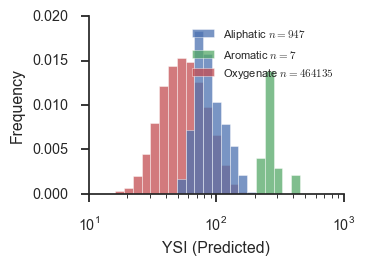

In [6]:
fig = plt.figure(figsize=(3.75,2.75))

data = np.random.normal(size=10000)
plt.hist(aliph['mean'],
         bins=np.logspace(1, 3, 30), normed=True, edgecolor='w', alpha=0.75,
         label='Aliphatic $n = {}$'.format(len(aliph)), zorder=2)
plt.hist(aro['mean'],
         bins=np.logspace(1, 3, 30), normed=True, edgecolor='w', alpha=0.75,
         label='Aromatic $n = {}$'.format(len(aro)))
plt.hist(pred[pred.oxygenate]['mean'],
         bins=np.logspace(1, 3, 30), normed=True, edgecolor='w', alpha=0.75,
         label='Oxygenate $n = {}$'.format(pred.oxygenate.sum()))

# plt.hist(aliph['mean'],
#          bins=np.logspace(1, 3, 30), normed=True, edgecolor='w', alpha=0.75, label='Aliphatic')

plt.gca().set_xscale("log")
plt.xlim([10, 1000])

plt.yticks(np.linspace(0, 0.02, 5))
plt.xlabel('YSI (Predicted)')
plt.ylabel('Frequency')

plt.legend(loc='upper right', fontsize=8)

sns.despine()
fig.tight_layout()
# fig.savefig('figures/eight_carbon_ysi.svg', transparent=True)

In [7]:
from fragdecomp.fragment_decomposition import draw_mol_svg

In [8]:
pred[pred.oxygenate].set_index('SMILES')['mean'].argmax()

'Oc1c(O)c2c(O)c(c1O)C=C2'

In [9]:
pred.set_index('SMILES').loc['Oc1c(O)c2c(O)c(c1O)C=C2']

mean         523.692
std          74.3944
oxygenate       True
Name: Oc1c(O)c2c(O)c(c1O)C=C2, dtype: object

In [10]:
pred[pred.oxygenate].set_index('SMILES')['mean'].max()

523.6924268073783

In [11]:
with open('fragment_images/eight_oxy_max.svg', 'w') as f:
    f.write(draw_mol_svg('Oc1c(O)c2c(O)c(c1O)C=C2'))

In [12]:
pred[~pred.oxygenate].set_index('SMILES')['mean'].argmax()

'c1ccc2c(c1)CC2'

In [13]:
pred[~pred.oxygenate].set_index('SMILES')['mean'].max()

387.51874248954607

In [14]:
with open('fragment_images/eight_aro_max.svg', 'w') as f:
    f.write(draw_mol_svg('c1ccc2c(c1)CC2'))

In [15]:
aliph.set_index('SMILES')['mean'].argmax()

'C1=CC2=CC=CC2=C1'

In [16]:
aliph.set_index('SMILES')['mean'].max()

191.38902065981716

In [17]:
with open('fragment_images/eight_ali_max.svg', 'w') as f:
    f.write(draw_mol_svg('C1=CC2=CC=CC2=C1'))

### Minimum

In [18]:
pred[pred.oxygenate].set_index('SMILES')['mean'].argmin()

'O=CCCCC(=O)C(=O)CC=O'

In [19]:
pred[pred.oxygenate].set_index('SMILES')['mean'].min()

13.138891844935946

In [20]:
with open('fragment_images/eight_oxy_min.svg', 'w') as f:
    f.write(draw_mol_svg('O=CCCCC(=O)C(=O)CC=O'))

In [21]:
aliph.set_index('SMILES')['mean'].argmin()

'CCCCCCCC'

In [22]:
aliph.set_index('SMILES')['mean'].min()

46.531856307451328

In [23]:
with open('fragment_images/eight_ali_min.svg', 'w') as f:
    f.write(draw_mol_svg('CCCCCCCC'))

# Overview of the captured and missed fragments

In [24]:
all_frags = pd.read_csv('data/eight_carbon_fragments.csv', index_col=0, header=None)[1]
sorted_frags = all_frags.sort_values()

ysi = pd.read_csv('ysi.csv').set_index('SMILES')
fragments = pd.read_csv('fragments.csv', index_col=0)

In [25]:
fragments.columns[fragments.columns.str.contains('O') & fragments.columns.str.contains('c')]

Index(['[c]-[C](-[c])=[O]', '[c]:[c](:[c])-[O] | (Ring)'], dtype='object')

In [26]:
in_low = set(fragments.columns[fragments[ysi.Ref == 3].astype(bool).any()])
in_high = set(fragments.columns[fragments[ysi.Ref.isin([1,2,4])].astype(bool).any()])
in_new = set(fragments.columns[fragments[ysi.Ref.isnull()].astype(bool).any()])

eight = set(sorted_frags.index)

In [27]:
from matplotlib_venn import venn3, venn3_circles

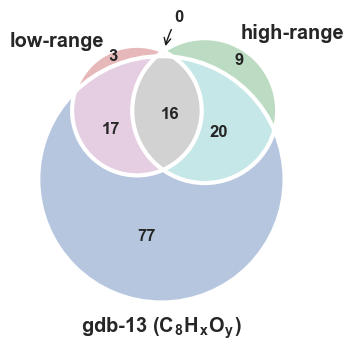

In [28]:
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

v = venn3([in_low, in_high, eight],
          set_labels=('low-range', 'high-range', 'gdb-13 ($\mathregular{C_8 H_x O_y}$)'),
          subset_label_formatter=lambda x: '' if x == 0 else x)
c = venn3_circles([in_low, in_high, eight], linestyle='solid', linewidth=3, color='w')

plt.annotate('0', xy=v.get_label_by_id('110').get_position() - np.array([0, -0.025]), xytext=(10,20),
             ha='center', textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',color='k',lw=1))

# plt.savefig('figures/fragment_venn.svg', transparent=True)

In [41]:
top_missing = sorted_frags[~sorted_frags.index.isin(fragments.columns)][::-1].head(10)
top_missing

0
[C]-[C](-[C])(-[C])-[O] | (Ring)     466396
[C]-[C](=[C])-[O] | (Ring)           298905
[C]-[C](-[O])=[O] | (Ring)           252896
[H]-[C](=[C])-[O] | (Ring)           242708
[H]-[C]1(-[C])-[C]-[C]-1 | (Ring)    225573
[H]-[C]1(-[O])-[C]-[C]-1 | (Ring)    204622
[C]-[C]1(-[O])-[C]-[C]-1 | (Ring)    166825
[H]-[C](=[C])-[O]                    108265
[C]-[C]1(-[C])-[C]-[O]-1 | (Ring)    105943
[C]-[C](-[C])(-[O])-[O] | (Ring)      75509
Name: 1, dtype: int64

Missing:
* tertiary alcohol in a ring
* alcohol attached to cyclic-alkene
* carboxylic acid in ring
* alcohol attached to terminal alkene

In [50]:
fragments_sparse.loc[:, top_missing.index].astype(bool).sum(1).argmax()

'C=COC1=COC2C1C2(C)O'

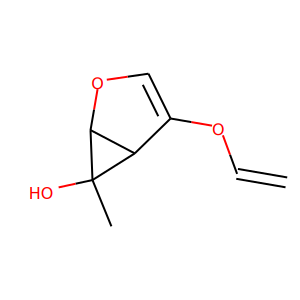

In [58]:
from IPython.display import SVG
SVG(draw_mol_svg('C=COC1=COC2C1C2(C)O'))

In [63]:
still_missing = top_missing[fragments_sparse.loc['C=COC1=COC2C1C2(C)O', top_missing.index] == 0]
still_missing

0
[C]-[C](-[C])(-[C])-[O] | (Ring)     466396
[C]-[C](-[O])=[O] | (Ring)           252896
[C]-[C]1(-[C])-[C]-[O]-1 | (Ring)    105943
[C]-[C](-[C])(-[O])-[O] | (Ring)      75509
Name: 1, dtype: int64

In [61]:
fragments_sparse.loc[:, still_missing.index].astype(bool).sum(1).argmax()

'CC12CC3(CO3)C(C)(CO1)O2'

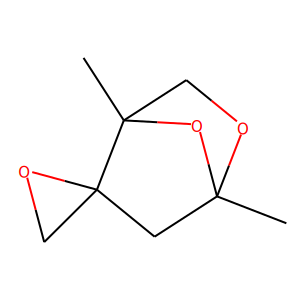

In [62]:
SVG(draw_mol_svg('CC12CC3(CO3)C(C)(CO1)O2'))

In [66]:
still_missing = still_missing[fragments_sparse.loc['CC12CC3(CO3)C(C)(CO1)O2', still_missing.index] == 0]
still_missing

0
[C]-[C](-[O])=[O] | (Ring)    252896
Name: 1, dtype: int64

In [69]:
contains = fragments_sparse[fragments_sparse['[C]-[C](-[O])=[O] | (Ring)'] != 0]

In [74]:
contains.iloc[1095].name

'CC1CCCCCOC1=O'

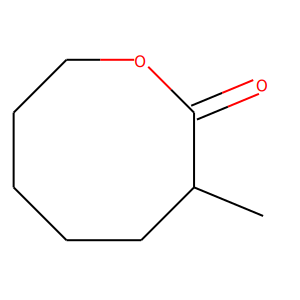

In [75]:
SVG(draw_mol_svg('CC1CCCCCOC1=O'))

In [42]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts

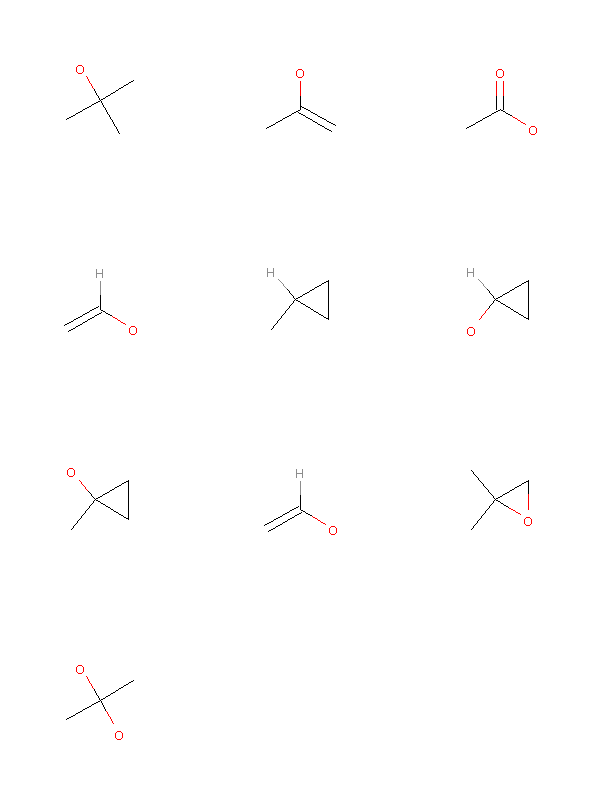

In [64]:
frag_mols = [MolFromSmarts(smiles) for smiles in top_missing.index.str.replace(' \|.*$', '')]
MolsToGridImage(frag_mols)

In [38]:
with open('fragment_images/missing_frags.svg', 'w') as f:
    f.write(MolsToGridImage(frag_mols, useSVG=True, subImgSize=(100, 100),
                            molsPerRow=3, legends=top_missing.values))

ArgumentError: Python argument types in
    MolDraw2D.DrawMolecule(MolDraw2DSVG, Mol)
did not match C++ signature:
    DrawMolecule(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, boost::python::api::object highlightAtoms, boost::python::api::object highlightBonds, boost::python::api::object highlightAtomColors=None, boost::python::api::object highlightBondColors=None, boost::python::api::object highlightAtomRadii=None, int confId=-1, std::string legend='')
    DrawMolecule(RDKit::MolDraw2D {lvalue} self, RDKit::ROMol mol, boost::python::api::object highlightAtoms=None, boost::python::api::object highlightAtomColors=None, boost::python::api::object highlightAtomRadii=None, int confId=-1, std::string legend='')